# Initialization

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
from result_saver import SaverProvider

provider = SaverProvider()

In [6]:
from Scratch import create_or_load_kde_grid

grid_dict, processed_scaler_dict = create_or_load_kde_grid(provider, tobecalib_backend=DEVICE, 
                                                           num_grid_points=300, num_std_dev=2, other_date=OTHER_DATE)

Found jobs for backend ibm_sherbrooke with closest execution date 2023-10-27 08:32:22.841567+00:00.
Searching for ibm_sherbrooke and 23.10.27_07h46_300pts_2std


# Generate IQ data

In [5]:
from soft_info import RepCodeIQSimulator

DEVICE = 'ibm_sherbrooke'
DISTANCE = 3
ROUNDS = 3
OTHER_DATE = '2021-11-11'
_RESETS = False

_is_hex = True
if DEVICE == 'ibmq_mumbai':
    _is_hex = False

# Initialize simulator
simulator = RepCodeIQSimulator(provider, DISTANCE, ROUNDS, DEVICE, _is_hex=_is_hex, _resets = _RESETS, other_date=OTHER_DATE)

Found jobs for backend ibm_sherbrooke with closest execution date 2023-10-27 08:32:22.841567+00:00.


circuit = simulator.code.circuit["0"] 
circuit.draw(fold=-1)

In [7]:
# Get noise model
p1Q = 0
pZ = 0
pRE = 0
pXY = 0

p2Q = 1e-2
# pRO = 15e-2
pRO = 0


# p1Q = 1e-4
# p2Q = 6e-3
# pXY = 1e-4
# pZ = 1e-4
# pRO = 1e-1
# pRE = 1e-3

noise_model = simulator.get_noise_model(p1Q, p2Q, pXY, pZ, pRO, pRE)

In [8]:
SHOTS = int(1e4)
LOGICAL = 1
IQ_data = simulator.generate_IQ(SHOTS, noise_model=noise_model, logical=LOGICAL)

17:38:20 Warning: Getting counts via stim. This may take time.... IN FILE: /Users/mha/My_Drive/Desktop/Studium/Physik/MSc/Semester_3/IBM/IBM_GIT/Soft-Info/src/soft_info/IQ_data/simulator.py, LINE: 46


100%|██████████| 20/20 [00:00<00:00, 484.13it/s]


# Decode resets = True

In [9]:
import pymatching
import stim


circuit = stim.Circuit.generated("repetition_code:memory",
                                distance=DISTANCE,
                                rounds=ROUNDS,
                                after_clifford_depolarization=p2Q, #two-qubit-fidelity,
                                after_reset_flip_probability=pRE, #reset error,
                                before_measure_flip_probability=pRO, #measurement error,
                                before_round_data_depolarization=pXY + pZ) #idle error)
# print(circuit)

model = circuit.detector_error_model(decompose_errors=True)
matching = pymatching.Matching.from_detector_error_model(model)

In [10]:
import cpp_soft_info

matching = pymatching.Matching.from_detector_error_model(model)
# cpp_soft_info.reweight_edges_based_on_error_probs(matching._matching_graph, counts, False, "spitz")

p_data = 6.869e-1 # mean sherbrooke noise
result = cpp_soft_info.decode_IQ_shots(matching._matching_graph, IQ_data,
                                           ROUNDS, int(LOGICAL), True, simulator.qubit_mapping, grid_dict,
                                           processed_scaler_dict, p_data=-1, p_mixed=-1, #p_mixed=1e-80, for d=30
                                           common_measure=-1, _bimodal=True, merge_strategy = "replace")
print("num_errors:", result.num_errors, "out of", len(IQ_data), "shots")

num_errors: 179 out of 10000 shots


In [13]:
matching = pymatching.Matching.from_detector_error_model(model)
num_errors = cpp_soft_info.decode_IQ_shots_flat(matching._matching_graph, IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, grid_dict,
                                           processed_scaler_dict)
print("num_errors:", num_errors.num_errors, "out of", len(IQ_data), "shots")


num_errors: 55 out of 10000 shots


In [14]:
matching = pymatching.Matching.from_detector_error_model(model)

import numpy as np
def weight_to_prob(weight):
    return 1/(1+np.exp(weight))

p_data = 1.869e-3# mean sherbrooke ECR error
p_mixed = p_data/10# Same as weighted
# p_meas = 1e-3
p_meas = 15.900e-2 # random found number


p_data = -1
p_mixed = -1
p_meas = -1

num_errors = cpp_soft_info.decode_IQ_shots_flat_informed(matching._matching_graph, IQ_data, 
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, grid_dict, processed_scaler_dict,
                                           p_data = p_data, p_mixed = p_mixed, p_meas = p_meas, common_measure=-1)

print("num_errors:", num_errors.num_errors, "out of", len(IQ_data), "shots")
         
# takes 1s

num_errors: 53 out of 10000 shots


# Decode resets = False

In [31]:
import pymatching
import stim


circuit = stim.Circuit.generated("repetition_code:memory",
                                distance=DISTANCE,
                                rounds=ROUNDS,
                                after_clifford_depolarization=p2Q, #two-qubit-fidelity,
                                after_reset_flip_probability=pRE, #reset error,
                                before_measure_flip_probability=pRO, #measurement error,
                                before_round_data_depolarization=pXY + pZ) #idle error)
# print(circuit)

model = circuit.detector_error_model(decompose_errors=True)
matching = pymatching.Matching.from_detector_error_model(model)

In [32]:
import cpp_soft_info

matching = pymatching.Matching.from_detector_error_model(model)
# cpp_soft_info.reweight_edges_based_on_error_probs(matching._matching_graph, counts, False, "spitz")

p_data = 6.869e-1 # mean sherbrooke noise
num_errors = cpp_soft_info.decode_IQ_shots(matching._matching_graph, IQ_data,
                                           ROUNDS, int(LOGICAL), False, simulator.qubit_mapping, grid_dict,
                                           processed_scaler_dict, p_data=-1, p_mixed=-1, #p_mixed=1e-80, for d=30
                                           common_measure=-1, _bimodal=True, merge_strategy = "replace")
print("num_errors:", num_errors.num_errors, "out of", len(IQ_data), "shots")

num_errors: 1465 out of 10000 shots


In [33]:
matching = pymatching.Matching.from_detector_error_model(model)
num_errors = cpp_soft_info.decode_IQ_shots_flat(matching._matching_graph, IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, grid_dict,
                                           processed_scaler_dict)
print("num_errors:", num_errors.num_errors, "out of", len(IQ_data), "shots")


num_errors: 705 out of 10000 shots


In [ ]:
matching = pymatching.Matching.from_detector_error_model(model)

import numpy as np
def weight_to_prob(weight):
    return 1/(1+np.exp(weight))

p_data = 1.869e-3# mean sherbrooke ECR error
p_mixed = p_data/10# Same as weighted
# p_meas = 1e-3
p_meas = 15.900e-2 # random found number


p_data = -1
p_mixed = -1
p_meas = -1

num_errors = cpp_soft_info.decode_IQ_shots_flat_informed(matching._matching_graph, IQ_data, 
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, grid_dict, processed_scaler_dict,
                                           p_data = p_data, p_mixed = p_mixed, p_meas = p_meas, common_measure=-1)

print("num_errors:", num_errors.num_errors, "out of", len(IQ_data), "shots")
         
# takes 1s

num_errors: 597 out of 10000 shots


# Use the qiskit circuit for stim

In [26]:
from qiskit_qec.circuits import RepetitionCodeCircuit

code = RepetitionCodeCircuit(DISTANCE, ROUNDS, resets=True)
circuit = code.circuit["0"]

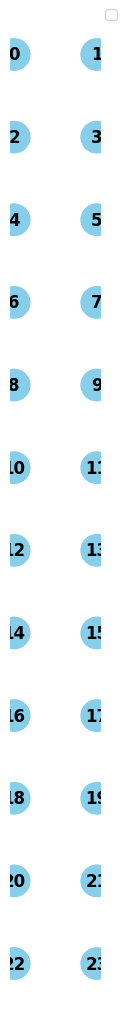

0

In [27]:
import pymatching
import stim

# get the stim circuit from the qiskit circuit
from qiskit_qec.utils import get_stim_circuits, noisify_circuit

# circuit = simulator.code.circuit[str(LOGICAL)]
circuit = noisify_circuit(circuit, noise_model)

stim_circuit, _ = get_stim_circuits(circuit)
stim_circuit = stim_circuit[0]
# print(stim_circuit)
model = stim_circuit.detector_error_model(approximate_disjoint_errors=True, decompose_errors=True)
matching = pymatching.Matching.from_detector_error_model(model)

from soft_info import draw_matching_graph

draw_matching_graph(matching, DISTANCE, ROUNDS, figsize=(10, 10))
matching._matching_graph.get_num_nodes()